In [1]:
import pandas as pd

In [6]:
# загружаем датасет 1
news = pd.read_csv("C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!Теория/Q4.MLiB/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [7]:
# загружаем датасет 2
users = pd.read_csv("C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!Теория/Q4.MLiB/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [8]:
# загружаем датасет 3
target = pd.read_csv("C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!Теория/Q4.MLiB/users_churn.csv")
target.head(10)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0
5,u102598,0
6,u107753,0
7,u103650,0
8,u106926,0
9,u103486,0


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

In [9]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install gensim

In [11]:
pip install pymorphy2

In [12]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install razdel

Note: you may need to restart the kernel to use updated packages.


### Получаем векторные представления новостей

In [14]:
from gensim.corpora.dictionary import Dictionary

In [15]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#pip install razdel

import pymorphy2  # pip install pymorphy2

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sklod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# загрузим стоп слова русского языка
stopword_ru = stopwords.words('russian')
len(stopword_ru)

# Создаем морфологический анализатор (позволяет привести слова с разными окончаниями к общей форме)
morph = pymorphy2.MorphAnalyzer()

In [18]:
# добавим к стоп-словам еще один список из нашего дополнительного файла

with open('C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!Теория/Q4.MLiB/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [19]:
# очистка текста - на выходе очищеный текст

def clean_text(text):

    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

# лемматизация - на выходе лист отлемматизированых токенов

def lemmatization(text):
    '''
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова    
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [20]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [21]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

<ipython-input-19-9be567cf6cad>:12: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателяnправительства рфnсерг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [22]:
lemmatization(norm_text[0])

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'сообщать',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'это',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'nn',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'представитель',
 'президент',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'nn',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'поли

In [23]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 18min 7s


In [24]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 34min 9s


In [25]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, 1/16, финал, кубок, россия, футбол, при...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, 50, год, тропический, углеродный, ...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [29]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
# создаем словарь из всех встречающихся в датасете слов
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts] #формируем bag of words

In [36]:
common_dictionary[4]

'армеец'

In [37]:
common_dictionary.id2token

{0: 'nn',
 1: 'александр',
 2: 'алексей',
 3: 'андрей',
 4: 'армеец',
 5: 'банк',
 6: 'баскетбол',
 7: 'близкий',
 8: 'блок',
 9: 'борьба',
 10: 'ватутин',
 11: 'взаимодействие',
 12: 'власть',
 13: 'войти',
 14: 'вячеслав',
 15: 'генерал-полковник',
 16: 'генеральный',
 17: 'георгий',
 18: 'гмк',
 19: 'директор',
 20: 'европа',
 21: 'единогласно',
 22: 'заместитель',
 23: 'заседание',
 24: 'защита',
 25: 'иванов',
 26: 'избрать',
 27: 'исакович',
 28: 'клиентский',
 29: 'клуб',
 30: 'конституционный',
 31: 'корпоративный',
 32: 'леонид',
 33: 'лопата',
 34: 'министр',
 35: 'мир',
 36: 'начальник',
 37: 'никель',
 38: 'новак',
 39: 'норильский',
 40: 'оао',
 41: 'обсуждение',
 42: 'округ',
 43: 'ольга',
 44: 'ооо',
 45: 'орган',
 46: 'основной',
 47: 'пбк',
 48: 'первый',
 49: 'перспектива',
 50: 'планирование',
 51: 'плешаков',
 52: 'политика',
 53: 'полномочный',
 54: 'полтавец',
 55: 'полтавченко',
 56: 'правительство',
 57: 'правление',
 58: 'председатель',
 59: 'представитель',
 6

#### Обучаем модель

In [38]:
from gensim.models import LdaModel

In [39]:
N_topic = 20 # число тем - гиперпараметр

In [40]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 3min 17s


In [41]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [42]:
# Create a new corpus, made of previously unseen documents.
# сформируем новый мешок слов из документов, которые ранее не были задействованы

other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.14312775),
 (9, 0.060847946),
 (12, 0.19048798),
 (15, 0.4104736),
 (16, 0.17832252)]

In [43]:
x=lda.show_topics(num_topics=20, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: экипаж топливо высота египет проверка девочка женщина секунда метр земля
topic_1: газ автор товар больной маршрут прогнозировать фрагмент пространство теория сценарий
topic_2: сша военный американский это район свой армия км гражданский год
topic_3: год который исследование млрд млн это тыс рост рубль компания
topic_4: рубль участок торговый продукция строительство площадь 2019 объект сократиться комплекс
topic_5: станция nn космос обвинение убийство вино суд следователь дело параметр
topic_6: рак com устойчивый мэй берег nn поймать тенденция компонент стресс
topic_7: годовой место рейтинг вдвое бомба эстония испания занять третий взорваться
topic_8: северный мышь фонд конструкция корея южный определение кг сон ким
topic_9: наука nn программа пройти фестиваль мероприятие сайт специальный участник который
topic_10: ребёнок человек это который гражданин год журнал мочь помощь ракета
topic_11: который россия дело это российский свой также глава заявить рф
topic_12: год земля банк

In [44]:
news['title'].iloc[5]

['главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'nn',
 'прежде',
 'весь',
 'хотеть',
 'поблагодарить',
 'свой',
 'ребята',
 'весь',
 'команда',
 'передавать',
 'слово',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'мочь',
 'это',
 'связать',
 'это',
 'дневный',
 'матч',
 'непривычный',
 'время',
 'плюс',
 'это',
 'третий',
 'матч',
 'сибирь',
 'где-то',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'стать',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'считать',
 'заслуженно',
 'победить']

In [45]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(5, 0.06163816),
 (7, 0.11139749),
 (9, 0.08721866),
 (11, 0.3558885),
 (15, 0.3132409),
 (19, 0.04753825)]

In [46]:
#Давайте напишем функцию, которая будет нам возвращать векторное представление новости
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(20):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [47]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.000000,0.0,0.064046,0.000000,0.0,0.0,...,0.0,0.685353,0.000000,0.066619,0.0,0.027161,0.070609,0.000000,0.0,0.000000
1,4896,0.0,0.0,0.0,0.000000,0.0,0.121693,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.196369,0.000000,0.660676,0.0,0.000000
2,4897,0.0,0.0,0.0,0.143086,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.190492,0.000000,0.0,0.410456,0.178340,0.000000,0.0,0.000000
3,4898,0.0,0.0,0.0,0.000000,0.0,0.000000,0.029228,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.147024,0.635551,0.000000,0.0,0.000000
4,4899,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.297992,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.433877


### Следующий шаг - векторные представления пользователей

In [48]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [74]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(20)]].values))

In [75]:
doc_dict[293622]

array([0.        , 0.02012937, 0.        , 0.05562271, 0.        ,
       0.        , 0.02759654, 0.        , 0.01910659, 0.10430631,
       0.12653135, 0.13319995, 0.25296417, 0.        , 0.06100871,
       0.        , 0.14107576, 0.        , 0.        , 0.05172316])

In [76]:
user_articles_list = users['articles'].iloc[33]

# Функция для получения вектора пользователя по темам прочитанных статей
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [77]:
user_articles_list = users['articles'].iloc[33]

vv = get_user_embedding(user_articles_list)
vv

array([0.        , 0.02153475, 0.05811025, 0.12996071, 0.00430851,
       0.08091758, 0.00866318, 0.01855793, 0.        , 0.03003508,
       0.04393731, 0.16967318, 0.02549477, 0.        , 0.10703636,
       0.        , 0.26384374, 0.02417628, 0.00235135, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [53]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.003355,0.036997,0.139724,0.000000,0.016516,0.004599,0.003032,0.013644,...,0.119068,0.149144,0.042161,0.007391,0.036103,0.0,0.133112,0.103652,0.000000,0.053226
1,u108690,0.002013,0.003311,0.071464,0.058963,0.003950,0.026685,0.000000,0.000000,0.000000,...,0.074297,0.201574,0.062341,0.002310,0.029037,0.0,0.394223,0.023733,0.007814,0.017136
2,u108339,0.002165,0.006185,0.055563,0.089159,0.014835,0.038136,0.000000,0.002158,0.000000,...,0.050970,0.292801,0.056019,0.000000,0.062289,0.0,0.124631,0.149366,0.000000,0.013133


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [79]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.003355,0.036997,0.139724,0.000000,0.016516,0.004599,0.003032,0.013644,...,0.149144,0.042161,0.007391,0.036103,0.0,0.133112,0.103652,0.000000,0.053226,0
1,u108690,0.002013,0.003311,0.071464,0.058963,0.003950,0.026685,0.000000,0.000000,0.000000,...,0.201574,0.062341,0.002310,0.029037,0.0,0.394223,0.023733,0.007814,0.017136,1
2,u108339,0.002165,0.006185,0.055563,0.089159,0.014835,0.038136,0.000000,0.002158,0.000000,...,0.292801,0.056019,0.000000,0.062289,0.0,0.124631,0.149366,0.000000,0.013133,1


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [85]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [86]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [88]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22607792, 0.04697026, 0.39387947, 0.13031703, 0.07538078,
       0.20579872, 0.0766266 , 0.02609941, 0.08541911, 0.08297917])

In [89]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score

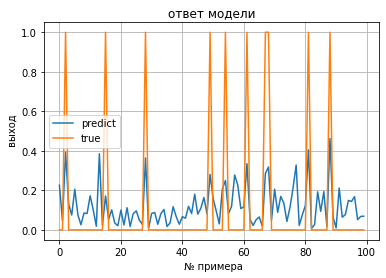

In [90]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

In [91]:
#По графику видно, что threshold должен быть существенно ниже 0.5. Получим его лучшее значение ниже:

precision, recall, thresholds = precision_recall_curve(y_test.values[:1000], preds[:1000])

n=-1
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix_ = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_], 
                                                                        fscore[ix_],
                                                                        precision[ix_],
                                                                        recall[ix_]))

Best Threshold=0.205990, F-Score=0.631, Precision=0.513, Recall=0.820


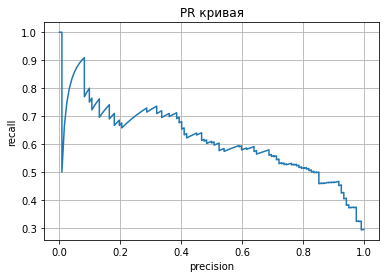

In [92]:
plt.plot(recall,precision )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

In [93]:
import itertools

In [94]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1556  199]
 [  48  197]]


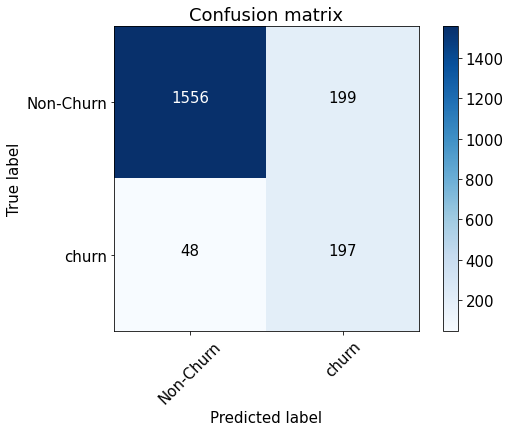

In [95]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix_])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [96]:
roc_auc_score_ = roc_auc_score(y_test, preds)
roc_auc_score_

0.932403046688761

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу.

### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [97]:
# Функция для получения вектора пользователя по темам прочитанных статей с использованием МЕДИАНЫ
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector1 = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.median(user_vector1, 0)
    return user_vector1

In [98]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.0,0.000000,0.027811,0.000000,0.000000,0.0,0.0,0.008682,...,0.117500,0.000000,0.0,0.007927,0.0,0.161110,0.032038,0.0,0.048544,0
1,u108690,0.0,0.0,0.049475,0.022107,0.000000,0.014794,0.0,0.0,0.000000,...,0.122566,0.036587,0.0,0.019168,0.0,0.392236,0.006281,0.0,0.012243,1
2,u108339,0.0,0.0,0.026933,0.099760,0.007842,0.013346,0.0,0.0,0.000000,...,0.341788,0.052819,0.0,0.023633,0.0,0.111175,0.132111,0.0,0.006061,1


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [100]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

In [101]:
precision1, recall1, thresholds1 = precision_recall_curve(y_test.values[:1000], preds[:1000])

n=-1
fscore1 = (2 * precision1 * recall1) / (precision1 + recall1)

# locate the index of the largest f score
ix1 = np.argmax(fscore1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds1[ix1], 
                                                                        fscore1[ix1],
                                                                        precision1[ix1],
                                                                        recall1[ix1]))

Best Threshold=0.233850, F-Score=0.754, Precision=0.675, Recall=0.852


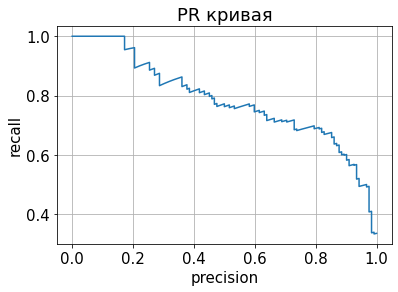

In [102]:
plt.plot(recall1,precision1 )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1673   82]
 [  49  196]]


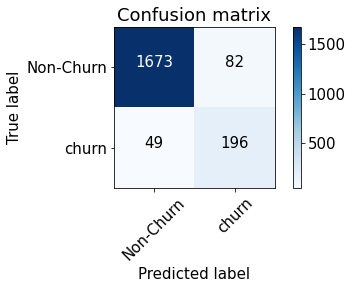

In [103]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds1[ix_])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [104]:
roc_auc_score1 = roc_auc_score(y_test, preds)
roc_auc_score1

0.9641769870341299

### 3. Повторить п.2, но используя уже не медиану, а max

In [105]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.max(user_vector, 0)  
    return user_vector1

In [106]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.020129,0.221984,0.457062,0.000000,0.099098,0.027597,0.018195,0.045395,...,0.416445,0.252964,0.044343,0.139754,0.0,0.258591,0.343383,0.000000,0.112005,0
1,u108690,0.012079,0.019867,0.176805,0.225003,0.023700,0.100801,0.000000,0.000000,0.000000,...,0.445833,0.202122,0.013860,0.077949,0.0,0.641628,0.102514,0.046882,0.053238,1
2,u108339,0.012991,0.037108,0.171950,0.160908,0.048575,0.122401,0.000000,0.012948,0.000000,...,0.440539,0.120329,0.000000,0.251355,0.0,0.246487,0.330435,0.000000,0.034119,1


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [108]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

In [109]:
precision2, recall2, thresholds2 = precision_recall_curve(y_test.values[:1000], preds[:1000])

n=-1
fscore2 = (2 * precision2 * recall2) / (precision2 + recall2)

# locate the index of the largest f score
ix2 = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))

Best Threshold=0.342191, F-Score=0.719, Precision=0.761, Recall=0.680


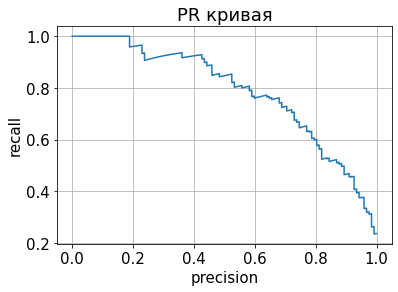

In [110]:
plt.plot(recall2,precision2 )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1353  402]
 [  12  233]]


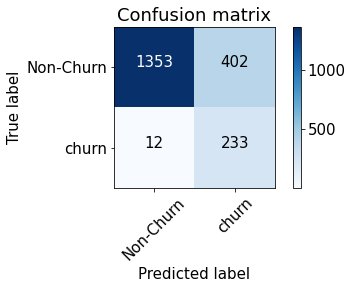

In [111]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds2[ix_])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [112]:
roc_auc_score2 = roc_auc_score(y_test, preds)
roc_auc_score2

0.9508110936682365

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [113]:
evaluation = pd.DataFrame({
    'тип усреднения': ['mean', 'median', 'max'],
    'precision': [precision[ix_], precision1[ix1], precision2[ix2]],
    'recall': [recall[ix_], recall1[ix1], recall2[ix2]],
    'F score': [fscore[ix_], fscore1[ix1], fscore2[ix2]],
    'ROC-AUC score': [roc_auc_score_, roc_auc_score1, roc_auc_score2],
})

evaluation

,тип усреднения,precision,recall,F score,ROC-AUC score
0,mean,0.512821,0.819672,0.630915,0.932403
1,median,0.675325,0.852459,0.753623,0.964177
2,max,0.761468,0.680328,0.718615,0.950811


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Высокие значения метрик достигаются при разбиении на 20 тем и при использовании максимального значения среди вероятностей каждой темы при формировании вектора пользователя. При max оказался худший показатель recall. Если мы выбираем max, то сильно падают показатели полноты (recall), то есть падает качество классификации - мы менее точно предсказываем количество покинувших портал пользователей, частично их пропуская. Mean по показателям кажется наиболее эффективной, т.к показатель отстает только для precision. Выбор способа зависит от важности каждой из метрик. 